In [ ]:
import os
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from tqdm import tqdm
from string import punctuation
from shapely.ops import snap, unary_union
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry import Point

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Подгружаем исходный датасет
df = pd.read_csv('/content/drive/MyDrive/ТГУ/HACKATON_SBER/Dmitriy/data/data_to_train.csv')

In [ ]:
# Датафрейм с распределением стран по количеству визитов на сайт
world_map = df['geo_country'].value_counts().reset_index()

# Строим график
fig = px.choropleth(
    data_frame=world_map,
    locations="geo_country", # Столбец с локациями
    locationmode = "country names", # Режим сопоставления локаций с базой plotly
    color="count",
    title='Страны по количеству визитов на сайт',
    range_color=[10, 10000], # Диапазон цетов
    width=1000, # Ширина
    height=700, # Высота
    color_continuous_scale=px.colors.sequential.Greens # Палитра цветов
)
fig.write_html('/content/drive/MyDrive/ТГУ/HACKATON_SBER/Dmitriy/Maps/Страны_по_количеству_визитов.html')
# pio.write_image(fig, '/content/drive/MyDrive/ТГУ/HACKATON_SBER/Dmitriy/Maps/Страны_по_количеству_визитов.png')
fig.show()

In [ ]:
# Датафрейм с распределением стран по количеству визитов на сайт
map_target = df.groupby('geo_country', as_index=False)['target'].value_counts().sort_values(by='count', ascending=False)
map_target.sample(5)

,geo_country,target,count
200,Sudan,0,6
58,Dominican Republic,0,140
143,Myanmar (Burma),0,11
106,Italy,0,324
49,Cuba,0,61


In [ ]:
# Строим график
fig = px.choropleth(
    data_frame=map_target,
    locations="geo_country", # Столбец с локациями
    locationmode = "country names", # Режим сопоставления локаций с базой plotly
    color='count',
    animation_frame="target",
    title='По количеству удачных и неудачных визитов',
    range_color=[10, 10000], # Диапазон цетов
    width=1000, # Ширина
    height=700, # Высота
    color_continuous_scale=px.colors.sequential.Viridis # Палитра цветов
)
fig.show()
fig.write_html('/content/drive/MyDrive/ТГУ/HACKATON_SBER/Dmitriy/Maps/Страны_по_таргету.html')

In [ ]:
# Собираем датафрейм по городам России
city = df[df['geo_country'] == 'Russia'][['geo_city','target']]
city_list = city['geo_city'].unique()
# Есть названия городов состоящие из цифр. Нужно удалить эти записи
city_dig = list(filter(lambda x: x.isdigit(), city_list))
print(city_dig)
# Удаляем записи с числовыми городами
city = city[~city['geo_city'].isin(city_dig)]
city_list = city['geo_city'].unique()

['83709', '92323', '53425', '8756', '39404', '9992', '24130', '88040', '14076', '75709', '13403']


In [ ]:
# Датафрейм из городов с количеством посещений сайта
city_visit = city['geo_city'].value_counts().reset_index()
city_visit

,geo_city,count
0,Moscow,116991
1,Saint Petersburg,64401
2,Yekaterinburg,12153
3,Kazan,11958
4,Krasnodar,11403
...,...,...
489,Osinovo,1
490,Troitsk,1
491,Zavidovo,1
492,Gorodishche,1


In [ ]:
# Читаем данные регионов России
gdf = gpd.read_file('/content/drive/MyDrive/ТГУ/HACKATON_SBER/Dmitriy/Maps/russia_regions.geojson')
gdf.info()
gdf.sample(4)

Output hidden; open in https://colab.research.google.com to view.

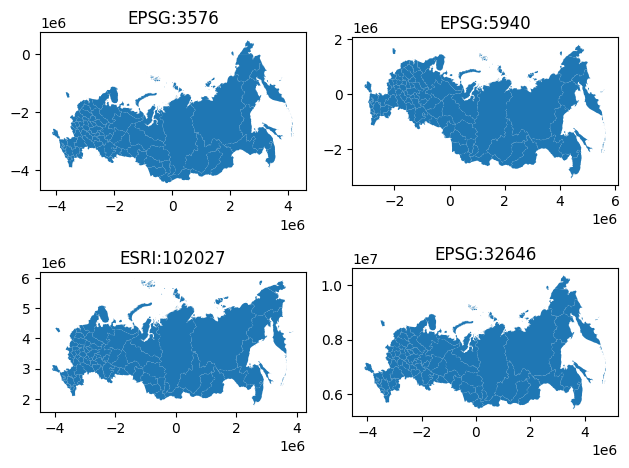

In [ ]:
# Выбор проекции для графика
crss = ['EPSG:3576', 'EPSG:5940', 'ESRI:102027', 'EPSG:32646']
fig = plt.figure()
for i, crs in enumerate(crss):
    ax = fig.add_subplot(2, 2, i+1)
    gdf.to_crs(crs).plot(ax=ax)
    ax.set_title(crs)
plt.tight_layout()
plt.show()

<Axes: >

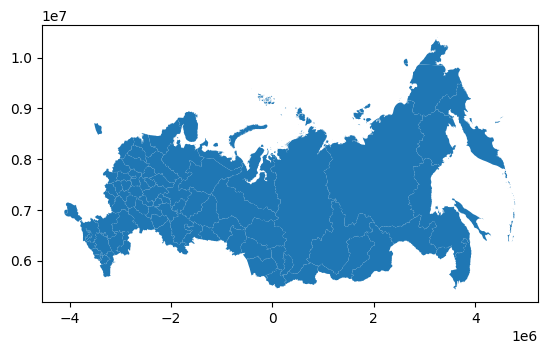

In [ ]:
# Выбранная проекция
gdf = gdf.to_crs('EPSG:32646')
gdf.plot()

In [ ]:
def prepare_regions(gdf, area_thr=100e6, simplify_tol=500):
    """
    - Упрощение геометрии с допуском simplify_tol
    - Удаление полигонов с площадью менее area_thr
    """
    gdf_ = gdf.copy()
    # Вспомогательный столбец для упорядочивания регионов по площади
    gdf_['area'] = gdf_.geometry.apply(lambda x: x.area)
    # Удаляем маленькие полигоны
    tqdm.pandas(desc='Удаление мелких полигонов')
    gdf_.geometry = gdf_.geometry.progress_apply(lambda geometry:
        MultiPolygon([p for p in geometry.geoms if p.area > area_thr])
            if type(geometry) == MultiPolygon else geometry
    )
        # Упрощение геометрии
    gdf_.geometry = gdf_.geometry.simplify(simplify_tol)

    geoms = gdf_.geometry.values
    pbar = tqdm(enumerate(geoms), total=len(geoms))
    pbar.set_description_str('Объединение границ после упрощения')
    # проходим по всем граничащим полигонам и объединяем границы
    for i, g in pbar:
        g1 = g
        for g2 in geoms:
            if g1.distance(g2) < 100:
                g1 = snap(g1, g2, 800)
        geoms[i] = g1
    gdf_.geometry = geoms

    # сортировка по площади
    gdf_ = gdf_.sort_values(by='area', ascending=False).reset_index(drop=True)

    return gdf_.drop(columns=['area'])

def geom2shape(g):
    """Преобразование полигонов и мультиполигонов в plotly-readable шэйпы
     Получает на вход Polygon или MultiPolygon из geopandas,
    возвращает pd.Series с координатами x и y
    """
    # Если мультиполигон, то преобразуем каждый полигон отдельно, разделяя их None'ами
    if type(g) == MultiPolygon:
        x, y = np.array([[], []])
        for poly in g.geoms:
            x_, y_ = poly.exterior.coords.xy
            x, y = (np.append(x, x_), np.append(y, y_))
            x, y = (np.append(x, None), np.append(y, None))
        x, y = x[:-1], y[:-1]
    # Если полигон, то просто извлекаем координаты
    elif type(g) == Polygon:
        x, y = np.array(g.exterior.coords.xy)
    # Если что-то другое, то возвращаем пустые массивы
    else:
        x, y = np.array([[], []])
    return pd.Series([x,y])

In [ ]:
# Упрощение геометрии
regions = prepare_regions(gdf)
# Преобразование полигонов в шейпы
regions[['x','y']] = regions.geometry.progress_apply(geom2shape)
# Запись на диск
# regions.to_parquet('/content/drive/MyDrive/ТГУ/HACKATON_SBER/Dmitriy/Maps/russia_regions.parquet')

Удаление мелких полигонов: 100%|██████████| 85/85 [00:00<00:00, 989.78it/s]


In [ ]:
'''Класс для слоя подложки карты России'''

REGIONS = pd.read_parquet('/content/drive/MyDrive/ТГУ/HACKATON_SBER/Dmitriy/Maps/russia_regions.parquet')

def convert_crs(x_arr, y_arr, to_crs='EPSG:32646', from_crs="EPSG:4326"):
    """Преобразование значений координат в массивах x_arr и y_arr
    из географической системы отсчёта from_crs в систему to_crs
    """
    data = [Point(x,y) for x,y in zip(x_arr, y_arr)]
    pts = gpd.GeoSeries(data, from_crs).to_crs(to_crs)

    return pts.x, pts.y

class mapFigure(go.Figure):
    """ Шаблон фигуры для рисования поверх карты России
    """
    def __init__(self, # дефолтные параметры plotly
        data=None, layout=None, frames=None, skip_invalid=False,
        **kwargs # аргументы (см. документацию к plotly.graph_objects.Figure())
    ):
        # создаём plotlу фигуру с дефолтными параметрами
        super().__init__(data, layout, frames, skip_invalid, **kwargs)

        # прорисовка регионов
        for i, r in REGIONS.iterrows():
            self.add_trace(go.Scatter(x=r.x, y=r.y,
                                      name=r.region,
                                      text=r.region,
                                      hoverinfo="text",
                                      line_color='grey',
                                      fill='toself',
                                      line_width=1,
                                      fillcolor='lightblue',
                                      showlegend=False
            ))

        # не отображать оси, уравнять масштаб по осям
        self.update_xaxes(visible=False)
        self.update_yaxes(visible=False, scaleanchor="x", scaleratio=1)

        # чтобы покрасивее вписывалась карта на поверхности фигуры
        self.update_layout(showlegend=False, dragmode='pan',
                           width=800, height=450,
                           margin={'l': 10, 'b': 10, 't': 10, 'r': 10})

In [ ]:
russia_map = mapFigure()
russia_map.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
regions = pd.read_parquet('/content/drive/MyDrive/ТГУ/HACKATON_SBER/Dmitriy/Maps/russia_regions.parquet')
regions.head()

,region,federal_district,population,geometry,x,y
0,Республика Саха (Якутия),Дальневосточный,997565,b'\x01\x06\x00\x00\x00\x0b\x00\x00\x00\x01\x03...,"[1934420.1169244426, 1940534.4765284657, 19409...","[8487439.714132698, 8486501.334447777, 8485674..."
1,Красноярский край,Сибирский,2845545,b'\x01\x06\x00\x00\x00\x13\x00\x00\x00\x01\x03...,"[32056.79935566982, 35462.3772034038, 36374.32...","[8132134.756812158, 8129810.54575796, 8125543...."
2,Хабаровский край,Дальневосточный,1284090,b'\x01\x06\x00\x00\x00\x02\x00\x00\x00\x01\x03...,"[3260155.6214775788, 3262629.3414506745, 32634...","[7013112.506960788, 7011116.731883681, 7011621..."
3,Чукотский автономный округ,Дальневосточный,47840,b'\x01\x06\x00\x00\x00\x05\x00\x00\x00\x01\x03...,"[3410612.8907587, 3409204.2168653556, 3408498....","[10234150.734028598, 10235463.675408207, 10237..."
4,Иркутская область,Сибирский,2344360,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\xe9\x0b...,"[672251.1376689398, 673691.300765981, 673446.4...","[6019892.874562745, 6017792.204244802, 6015136..."


In [ ]:
fo_list = list(regions['federal_district'].unique())
colors = px.colors.qualitative.Pastel1

for i, r in regions.iterrows():
    popul_text = f"Население: <b>{r.population:_} </b>".replace('_', ' ')
    text = f'<b>{r.region}</b><br>{r.federal_district} ФО<br>{popul_text}'
    russia_map.update_traces(selector=dict(name=r.region),
        text=text,
        fillcolor=colors[fo_list.index(r.federal_district)])
russia_map.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Подгружаем города
df_city = gpd.read_file('/content/drive/MyDrive/ТГУ/HACKATON_SBER/Dmitriy/Maps/russia_cities.geojson')
df_city.sample(4)

,city,population,region,federal_district,geometry
204,Абакан,186800,Республика Хакасия,Сибирский ФО,"POLYGON ((91.51261 53.61334, 91.52283 53.6134,..."
36,Красногорск,175600,Московская область,Центральный ФО,"POLYGON ((37.22282 55.84111, 37.23727 55.83981..."
46,Королёв,226900,Московская область,Центральный ФО,"POLYGON ((37.78789 55.91427, 37.78952 55.91422..."
27,Новомосковск,122300,Тульская область,Центральный ФО,"POLYGON ((38.46481 54.06798, 38.4665 54.06604,..."


In [ ]:
def prepare_cities(gdf):
    """Подготовка городов к построению"""
    gdf_ = gdf.copy()

    # Вспомогательный столбец
    gdf_['area'] = gdf_.geometry.apply(lambda x: x.area)

    # Упрощение геометрии
    gdf_.geometry = gdf_.geometry.simplify(500)

    geoms = gdf_.geometry.values
    pbar = tqdm(enumerate(geoms), total=len(geoms))
    pbar.set_description_str('Объединение границ после упрощения')
    for i, g in pbar:
        g1 = g
        for g2 in geoms:
            if g1.distance(g2) < 100:
                g1 = snap(g1, g2, 800)
        geoms[i] = g1
    gdf_.geometry = geoms

    # Преобразование полигонов и мультиполигонов в plotly-readable шэйпы
    def geom2shape(g):
        if type(g) == MultiPolygon:
            x, y = np.array([[], []])
            for poly in g.geoms:
                x_, y_ = poly.exterior.coords.xy
                x, y = (np.append(x, x_), np.append(y, y_))
                x, y = (np.append(x, None), np.append(y, None))
            x = x[:len(x)-1]
            y = y[:len(y)-1]
        else:
            x, y = np.array(g.exterior.coords.xy)
        return pd.Series([x,y])

    tqdm.pandas(desc='Преобразование полигонов в шейпы')
    gdf_[['x','y']] = gdf_.geometry.progress_apply(geom2shape)

    return gdf_.sort_index()

cities = prepare_cities(gdf)
cities = cities.sort_values(by='area', ascending=False).reset_index(drop=True) # сортировка по площади


Преобразование полигонов в шейпы: 100%|██████████| 85/85 [00:00<00:00, 470.07it/s]


In [ ]:
regions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   region            85 non-null     object
 1   federal_district  85 non-null     object
 2   population        85 non-null     int32 
 3   geometry          85 non-null     object
 4   x                 85 non-null     object
 5   y                 85 non-null     object
dtypes: int32(1), object(5)
memory usage: 3.8+ KB


In [ ]:
# Фомируем словарь из сгруппированных по регионам городов
city_gr = df_city.groupby('region', as_index=False)['city'].value_counts()[['region', 'city']].groupby('region')['city'].apply(', '.join).reset_index()
city_gr.info()
# В таблице regions создаем признак city

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   region  78 non-null     object
 1   city    78 non-null     object
dtypes: object(2)
memory usage: 1.3+ KB


In [ ]:
joined = city_gr.merge(
    regions.astype({'region': 'str'}),  # Приводим к string
    on='region',
    how='inner'
)
joined.head()

,region,city,federal_district,population,geometry,x,y
0,Алтайский край,"Барнаул, Бийск, Рубцовск",Сибирский,2130950,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00r\x02\x0...,"[-502010.3629756166, -502622.93211862934, -500...","[6020218.671739394, 6011564.5566946585, 600429..."
1,Амурская область,Благовещенск,Дальневосточный,756198,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00g\x07\x0...,"[2104548.394933197, 2108041.137446034, 2109971...","[6611762.074714982, 6610142.483085888, 6610611..."
2,Архангельская область,"Архангельск, Нарьян-Мар, Северодвинск",Северо-Западный,964304,b'\x01\x06\x00\x00\x00\x1e\x00\x00\x00\x01\x03...,"[-1482906.8884784165, -1489143.0120401161, -14...","[8207777.198343767, 8204730.490885935, 8201942..."
3,Астраханская область,Астрахань,Южный,950557,b'\x01\x06\x00\x00\x00\x02\x00\x00\x00\x01\x03...,"[-3088756.363902074, -3079366.6162457787, -308...","[6198627.654317704, 6190672.537588346, 6189164..."
4,Белгородская область,"Белгород, Старый Оскол",Центральный,1514527,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x13\x02...,"[-3291201.583861754, -3292020.982600556, -3290...","[7383947.53300637, 7382386.460946213, 7379780...."


In [ ]:
# Разделяем города по запятым и убираем пробелы
joined['city'] = joined['city'].str.split(',\s*')

# Применяем explode для создания отдельной строки для каждого города
result = joined.explode('city').reset_index(drop=True)
result.head()

,region,city,federal_district,population,geometry,x,y
0,Алтайский край,Барнаул,Сибирский,2130950,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00r\x02\x0...,"[-502010.3629756166, -502622.93211862934, -500...","[6020218.671739394, 6011564.5566946585, 600429..."
1,Алтайский край,Бийск,Сибирский,2130950,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00r\x02\x0...,"[-502010.3629756166, -502622.93211862934, -500...","[6020218.671739394, 6011564.5566946585, 600429..."
2,Алтайский край,Рубцовск,Сибирский,2130950,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00r\x02\x0...,"[-502010.3629756166, -502622.93211862934, -500...","[6020218.671739394, 6011564.5566946585, 600429..."
3,Амурская область,Благовещенск,Дальневосточный,756198,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00g\x07\x0...,"[2104548.394933197, 2108041.137446034, 2109971...","[6611762.074714982, 6610142.483085888, 6610611..."
4,Архангельская область,Архангельск,Северо-Западный,964304,b'\x01\x06\x00\x00\x00\x1e\x00\x00\x00\x01\x03...,"[-1482906.8884784165, -1489143.0120401161, -14...","[8207777.198343767, 8204730.490885935, 8201942..."


In [ ]:
cities_dict = {
    'Zlatoust': 'Златоуст',    'Moscow': 'Москва',    'Krasnoyarsk': 'Красноярск',    'Saint Petersburg': 'Санкт-Петербург',    'Sochi': 'Сочи',    'Yaroslavl': 'Ярославль',    'Mytishchi': 'Мытищи',
    'Novorossiysk': 'Новороссийск',    'Balashikha': 'Балашиха',    'Pushkino': 'Пушкино',    'Vladivostok': 'Владивосток',    'Alexandrov': 'Александров',    'Astrakhan': 'Астрахань',
    'Reutov': 'Реутов',    'Kazan': 'Казань',    'Ulyanovsk': 'Ульяновск',    'Yekaterinburg': 'Екатеринбург',    'Rostov-on-Don': 'Ростов-на-Дону',    'Samara': 'Самара',    'Domodedovo': 'Домодедово',
    'Yoshkar-Ola': 'Йошкар-Ола',    'Chelyabinsk': 'Челябинск',    'Krasnogorsk': 'Красногорск',    'Krasnodar': 'Краснодар',    'Lipetsk': 'Липецк',    'Nakhabino': 'Нахабино',    'Kyzyl': 'Кызыл',
    'Ryazan': 'Рязан ь',    'Tyumen': 'Тюмень',    'Omsk': 'Омск',    'Nizhny Novgorod': 'Нижний Новгород',    'Irkutsk': 'Иркутск',    'Mezhdurechensk': 'Междуреченск',    'Tuymazy': 'Туймазы',
    'Stupino': 'Ступино',    'Serpukhov': 'Серпухов',    'Saratov': 'Саратов',    'Grozny': 'Грозный',    'Orenburg': 'Оренбург',    'Surgut': 'Сургут',    'Volgograd': 'Волгоград',
    'Engels': 'Энгельс',    'Fryazino': 'Фрязино',    'Naberezhnye Chelny': 'Набережные Челны',    'Khabarovsk': 'Хабаровск',    'Ufa': 'Уфа',    'Novosibirsk': 'Новосибирск',    'Kirov': 'Киров',
    'Kotelniki': 'Котельники',    'Kaluga': 'Калуга',    'Vyborg': 'Выборг',    'Barnaul': 'Барнаул',    'Tambov': 'Тамбов',    'Tver': 'Тверь',    'Korolyov': 'Королев',    'Kostroma': 'Кострома',
    'Zheleznodorozhny': 'Железнодорожный',    'Dolgoprudny': 'Долгопрудный',    'Kursk': 'Курск',    'Pyatigorsk': 'Пятигорск',    'Khimki': 'Химки',    'Dubna': 'Дубна',    'Izhevsk': 'Ижевск',
    'Chita': 'Чита',    'Cherkessk': 'Черкесск',    'Blagoveshchensk': 'Благовещенск',    'Bryansk': 'Брянск',    'Voronezh': 'Воронеж',    'Kolomna': 'Коломна',    'Nalchik': 'Нальчик',
    'Obninsk': 'Обнинск',    'Belgorod': 'Белгород',    'Perm': 'Пермь',    'Severodvinsk': 'Северодвинск',    'Gatchina': 'Гатчина',    'Syktyvkar': 'Сыктывкар',    'Naro-Fominsk': 'Наро-Фоминск',
    'Protvino': 'Протвино',    'Kamensk-Uralsky': 'Камень-на-Оби',    'Zhukovskiy': 'Жуковский',    'Tomsk': 'Томск',    'Stavropol': 'Ставрополь',    'Ivanteyevka': 'Ивантеевка',    'Yegoryevsk': 'Егорьевск',
    'Magnitogorsk': 'Магнитогорск',    'Vidnoye': 'Видное',    'Abakan': 'Абакан',    'Kraskovo': 'Красково',    'Safonovo': 'Сафоново',    'Shlisselburg': 'Шлиссельбург',
    'Cherepovets': 'Череповец',    'Arkhangelsk': 'Архангельск',    'Lyubertsy': 'Люберцы',    'Vologda': 'Вологда',    'Petrozavodsk': 'Петрозаводск',    'Oryol': 'Орёл',    'Odintsovo': 'Одинцово',
    'Voskresensk': 'Воскресенск',    'Almetyevsk': 'Альметьевск',    'Veliky Novgorod': 'Великий Новгород',    'Kovrov': 'Ковров',    'Ramenskoye': 'Раменское',    'Berezniki': 'Березники',
    'Shchyolkovo': 'Щелково',    'Novocheboksarsk': 'Новочебоксарск',    'Maykop': 'Майкоп',    'Nefteyugansk': 'Нефтеюганск',    'Tomilino': 'Томилино',    'Kaliningrad': 'Калининград',
    'Vladimir': 'Владимир',    'Velikiye Luki': 'Великие Луки',    'Nakhodka': 'Находка',    'Nizhnevartovsk': 'Нижневартовск',    'Nevinnomyssk': 'Невинномысск',    'Klin': 'Клин',
    'Uchaly': 'Учалы',    'Novy Urengoy': 'Новый Уренгой',    'Smolensk': 'Смоленск',    'Dedovsk': 'Дедовск',    'Sergiyev Posad': 'Сергиев Посад',    'Vsevolozhsk': 'Всеволожск',
    'Dmitrov': 'Дмитров',    'Cheboksary': 'Чебоксары',    'Podolsk': 'Подольск',    'Pervouralsk': 'Первоуральск',    'Anapa': 'Анапа',    'Lytkarino': 'Лыткарино',    'Kopeysk': 'Копейск',    'Tosno': 'Тосно',    'Norilsk': 'Норильск',    'Tolyatti': 'Тольятти',
    'Temryuk': 'Темрюк',    'Petrovo-Dalneye': 'Петрово-Дальнее',    'Ussuriysk': 'Уссурийск',    'Istra': 'Истра',    'Murmansk': 'Мурманск',    'Ivanovo': 'Иваново',    'Verkhnyaya Pyshma': 'Верхняя Пышма',    'Maloyaroslavets': 'Малоярославец',
    'Tikhvin': 'Тихвин',    'Neryungri': 'Нерюнгри',    'Kurgan': 'Курган',    'Novomoskovsk': 'Новомосковск',    'Kemerovo': 'Кемерово',    'Volokolamsk': 'Волоколамск',
    'Elektrostal': 'Электросталь',    'Yablonovsky': 'Яблоновский',    'Essentuki': 'Ессентуки',    'Kislovodsk': 'Кисловодск',    'Malakhovka': 'Малаховка',    'Orekhovo-Zuyevo': 'Орехово-Зуево',
    'Angarsk': 'Ангарск',    'Chekhov': 'Чехов',    'Severomorsk': 'Североморск',
    'Leninsk-Kuznetskiy': 'Ленинск-Кузнецкий',    'Satka': 'Сатка',    'Dzerzhinsk': 'Дзержинск',   'Хомутово': 'Хомутово',    'Penza': 'Пенза',    'Biysk': 'Бийск',    'Novokuznetsk': 'Новокузнецк',    'Lobnya': 'Лобня',    'Novoye Devyatkino': 'Новое Девяткино',
    'Sterlitamak': 'Стерлитамак',    'Naryan-Mar': 'Нарьян-Мар',    'Kamyshin': 'Камышин',    'Artyom': 'Артём',
    'Yurga': 'Юрга',    'Asbest': 'Асбест',    'Sertolovo': 'Сертолово',    'Staraya Kupavna': 'Старая Купавна',    'Dzerzhinsky': 'Дзержинский',
    'Krasnoznamensk': 'Краснознаменск',    'Ulan-Ude': 'Улан-Удэ',    'Zarechnyy': 'Заречный',    'Kostomuksha': 'Костомукша',    'Povarovo': 'Поварово',
    'Meleuz': 'Мелеуз',    'Nazran': 'Назрань',    'Klimovsk': 'Климовск',    'Stary Oskol': 'Старый Оскол',    'Vorkuta': 'Воркута',
    'Poltavskaya': 'Полтавская',  'Lukhovitsy': 'Луховицы',    'Zagorjanskas': 'Загорянский',    'Beloozyorskiy': 'Белоозёрский',    'Belebey': 'Белебей',    'Elektrougli': 'Электроугли',
    'Chebarkul': 'Чебаркуль',    'Pskov': 'Псков',    'Ukhta': 'Ухта',    'Ruza': 'Руза',    'Nizhny Tagil': 'Нижний Тагил',    'Yakutsk': 'Якутск',    'Khotkovo': 'Хотьково',    'Elista': 'Элиста',
    'Bratsk': 'Братск',    'Noginsk': 'Ногинск',    'Makhachkala': 'Махачкала',    'Vladikavkaz': 'Владикавказ',    'Belovo': 'Белово',    'Frolovo': 'Фролово',    'Petropavlovsk-Kamchatskiy': 'Петропавловск-Камчатский',    'Borovichi': 'Боровичи',
    'Kratovo': 'Красково',    'Prokopyevsk': 'Прокопьевск',    'Seversk': 'Северск',    'Rybinsk': 'Рыбинск',
    'Pereslavl-Zalessky': 'Переславль-Залесский',    'Taganrog': 'Таганрог',    'Novouralsk': 'Новоуральск',    'Gelendzhik': 'Геленджик',    'Aramil': 'Арамиль',    'Novotroitsk': 'Новотроицк',    'Tuapse': 'Туапсе',    'Mozhaysk': 'Можайск',    'Sarov': 'Саров',
    'Kimry': 'Кимры',    'Kubinka': 'Кубинка',    'Zheleznogorsk': 'Железногорск',    'Saransk': 'Саранск',    'Dimitrovgrad': 'Димитровград',
    'Slavyansk-na-Kubani': 'Славянск-на-Кубани',    'Tikhoretsk': 'Тихорецк',    'Salekhard': 'Салехард',    'Ostrov': 'Осташков',    'Kommunar': 'Коммунар',    'Tsivilsk': 'Цивильск',    'Shakhty': 'Шахты',
    'Pechora': 'Печора',    'Svetogorsk': 'Светогорск',    'Bataysk': 'Батайск',    'Kirishi': 'Кириши',
    'Komsomolsk-on-Amur': 'Комсомольск-на-Амуре',    'Novocherkassk': 'Новочеркасск',    'Chernogolovka': 'Черноголовка',
    'Gorki-2': 'Горки-2',    'Gus-Khrustalny': 'Гусь-Хрустальный',    'Berdsk': 'Бердск',    'Lysva': 'Лысьва',    'Korsakov': 'Корсаков',
    'Sovetsk': 'Советск',    'Aprelevka': 'Апрелевка',    'Semibratovo': 'Семибратово',    'Pavlovsky Posad': 'Павловский Посад',    'Bor': 'Бор',    'Magadan': 'Магадан',
    'Kstovo': 'Кстово',    'Shatura': 'Шатура',    'Losino-Petrovsky': 'Лосино-Петровский',    'Yalutorovsk': 'Ялуторовск',
    'Ust-Ilimsk': 'Усть-Илимск',    'Pushchino': 'Пущино',    'Polysayevo': 'Полысаево',    'Tobolsk': 'Тобольск',    'Birobidzhan': 'Биробиджан',    'Lipitsy': 'Липицы',
    'Volgodonsk': 'Волгодонск',    'Yeysk': 'Ейск',    'Golitsyno': 'Голицыно',    'Miass': 'Миасс',    'Yelets': 'Елец',    'Zvenigorod': 'Звенигород',
    'Selyatino': 'Селятино',    'Volkhov': 'Волхов',    'Krasnoarmeysk': 'Красноармейск',    'Apatity': 'Апатиты',    'Solnechnogorsk': 'Солнечногорск',    'Buynaksk': 'Буйнакск',    'Krasnoturyinsk': 'Краснотурьинск',
    'Bolshoy Kamen': 'Большой Камень',    'Noyabrsk': 'Ноябрьск',    'Tynda': 'Тында',    'Nizhnekamsk': 'Нижнекамск',
    'Usolye-Sibirskoye': 'Усолье-Сибирское',    'Kingisepp': 'Кингисепп',    'Zhigulevsk': 'Жигулёвск',    'Zelenodolsk': 'Зеленодольск',
    'Glazov': 'Глазов',    'Achinsk': 'Ачинск',    'Rodniki': 'Родники',    'Shelekhov': 'Шелехов',    'Kaspiysk': 'Каспийск',    'Birsk': 'Бирск',    'Nadym': 'Надым',    'Gorno-Altaysk': 'Горно-Алтайск',
    'Kolchugino': 'Колчугино',    'Kushchyovskaya': 'Кущёвская',    'Yuzhnyy': 'Южный',    'Armavir': 'Армавир',
    'Kalininets': 'Калининский',    'Mozhga': 'Можга',    'Vyksa': 'Выкса',    'Uzlovaya': 'Узловая',    'Rostov': 'Ростов',
    'Kirovsk': 'Кировск',    "Ul'yanovka": 'Ульяновка',    'Novoaltaysk': 'Новоалтайск',    'Kamensk-Shakhtinsky': 'Камень-Шахтинский',    'Ozersk': 'Озёрск',    'Elektrogorsk': 'Электрогорск',    'Arzamas': 'Арзамас',
    'Snezhinsk': 'Снежинск',    'Borisoglebsk': 'Борисоглебск',    'Chusovskoye Urban Settlement': 'Чусовское Городское поселение',
    'Mirny': 'Мирный',    'Vyazniki': 'Вязники',    'Enem': 'Энем',    'Nyagan': 'Нягань',
    'Ruzayevka': 'Рузаевка',    'Khanty-Mansiysk': 'Ханты-Мансийск',    'Monino': 'Монино',    'Mineralnye Vody': 'Минеральные Воды',    'Verkhnyaya Salda': 'Верхняя Салда',
    'Russkiy': 'Русский',    'Revda': 'Ревда',    'Lesnoy Gorodok': 'Лесной Городок',
    'Argun': 'Аргун',    'Kyshtym': 'Кыштым',    'Salavat': 'Салават',    'Tuchkovo': 'Тучково',    'Kumertau': 'Кумертау',    'Polevskoy': 'Полевской',    'Mikhaylovka': 'Михайловка',    'Murom': 'Муром',    'Kineshma': 'Кинешма',
    'Kandalaksha': 'Кандалакша',    'Krasnouralsk': 'Красноуральск',    'Torzhok': 'Торжок',    'Yuzhnouralsk': 'Южноуральск',    'Shuya': 'Шуя',
    'Serov': 'Серов',    'Sosnovy Bor': 'Сосновый Бор',    'Shadrinsk': 'Шадринск',    'Kotlas': 'Котлас',
    'Novotitarovskaya': 'Новотитаровская',    'Balakovo': 'Балаково',    'Azov': 'Азов',    'Kirovo-Chepetsk': 'Кирово-Чепецк',   'Rubtsovsk': 'Рубцовск',
    'Kirzhach': 'Киржач',    'Anadyr': 'Анадырь',    'Khasavyurt': 'Хасавюрт',    'Troedobelikovskiy': 'Троедобеликовский',    'Beryozovsky': 'Берёзовский',
    'Derbent': 'Дербент',    'Dubovoe': 'Дубовое',    'Vyazma': 'Вязьма',    'Pyt-Yakh': 'Пыть-Ях',    'Semender': 'Семендер',    'Nikolskoye': 'Никольское',
    'Kashira': 'Кашира',    'Kizlyar': 'Кизляр',    'Zarinsk': 'Заринск',    'Konakovo': 'Конаково',    'Kurumoch': 'Курумоч',    'Udomlya': 'Удомля',
    'Minusinsk': 'Минусинск',    'Kropotkin': 'Кропоткин',    'Aleksandrovsk-Sakhalinskiy': 'Александровск-Сахалинский',    'Pavlovo': 'Павлово',
    'Otradny': 'Отрадный',    'Aksay': 'Акса́й',    'Balakhna': 'Балахна',    'Monchegorsk': 'Мончегорск',    'Kurchatov': 'Курчатов',    'Orsk': 'Орск',    'Beloretsk': 'Белорецк',    'Vyshny Volochyok': 'Высший Волочёк',    'Plastunovskaya': 'Пластуновская',
    'Nizhnyaya Tura': 'Нижняя Тура',    'Poronaysk': 'Поронайск',    'Oktyabrsky': 'Октябрьский',    'Shakhovskaya': 'Шаховская',    'Kizilyurt': 'Кизилюрт',
    'Chistopol': 'Чистополь',    'Kansk': 'Канск',    'Inta': 'Инта',    'Novoshakhtinsk': 'Новошахтинск',    'Arsenyev': 'Арсеньев',
    'Kartaly': 'Карталы',    'Kurovskoye': 'Куровское',    'Kuznetsk': 'Кузнецк',    'Rossosh': 'Россошь',    'Samarskoye': 'Самарское',    'Usinsk': 'Усинск',
    'Kanevskaya': 'Каневская',    'Lyuban': 'Любань',    'Dalnegorsk': 'Дальнегорск',    'Urus-Martan': 'Урус-Мартан',    'Votkinsk': 'Воткинск',    'Katav-Ivanovsk': 'Катав-Ивановск',    'Olginka': 'Ольгинска',    'Yakhroma': 'Яхрома',    'Novokuybyshevsk': 'Новокуйбышевск',    'Ishimbay': 'Ишимбай',    'Veliky Ustyug': 'Великий Устюг',
    'Sosnovoborsk': 'Сосновоборск',    'Gudermes': 'Гудермес',    'Labytnangi': 'Лабытнанги',    'Likino-Dulyovo': 'Ликино-Дулёво',    'Lodeynoye Pole': 'Лодейное Поле',
    'Dorokhovskoja': 'Дорогобужская',    'Syzran': 'Сызрань',    'Belaya Kalitva': 'Белая Калитва',    'Spassk-Dalny': 'Спасск-Дальний',    'Belorechensk': 'Белореченск',    'Sarapul': 'Сарапул',    'Raduzhny': 'Радужный',    'Trudovoye': 'Трудовое',
    "Emel'yanovo": 'Емельяново',    'Kinel': 'Кинель',    'Novomikhailovskii': 'Новомихайловский',    'Korkino': 'Коркино',    'Kiselyovsk': 'Киселёвск',    'Berezovka': 'Берёзовка',
    'Goryachevodsky': 'Горячий Ключ',    'Michurinsk': 'Мичуринск',    'Bobrovskiy': 'Бобровский',    'Voronezjskaja': 'Воронежская',
    'Chegem': 'Чегем',    'Wolno-Nadeschdinskoje': 'Свободненская',    'Yelizovo': 'Елизово',    'Тимофеевка': 'Тимофеевка',    'Ust-Labinsk': 'Уст-Лабинск',    'Starokorsunskaya': 'Старокорсунская',
    'Tarko-Sale': 'Таркосале',    'Kachkanar': 'Качканар',    'Iskitim': 'Искитим',    'Sibay': 'Сибай',    'Vlasikha': 'Власиха',    'Agoi': 'Агой',    'Zavolzhye': 'Заволжье',    'Priozersk': 'Приозерск',
    'Bologoye': 'Бологое',    'Тарасовка': 'Тарасовка',    'Beloyarsky': 'Белоярский',    'Ust-Katav': 'Усть-Катав',    'Kanash': 'Канаш',    'Dagestanskie Ogni': 'Дагестанские Огни',    'Belogorsk': 'Белогорск',    'Labinsk': 'Лабинск',    'Lyskovo': 'Лысково',    'Afipsky': 'Афипский',
    'Starnikovo': 'Старниково',    'Juravskaia': 'Юравская',    'Korenovsk': 'Кореновск',    'Znamenskiy': 'Знаменский',    'Slavgorod': 'Славгород',
    'Kungur': 'Кунгур',    'Gadzhiyevo': 'Гаджиево',    'Shchyokino': 'Щёкино',    'Nogliki': 'Ноглики',    'Bogolyubovo': 'Боголюбово',    'Artemovskiy': 'Артёмовский',
    'Lenina': 'Ленина',    'Gaiduk': 'Гайдук',    'Marks': 'Маркс',    'Kugesi': 'Кугеси',    'Solikamsk': 'Соликамск',    'Bryukhovetskaya': 'Брюховецкая',    'Slavyanka': 'Славянка',    "Industrial'nyy": 'Индустриальный',    'Menzelinsk': 'Менделеевск',    'Novoukrainskoye': 'Новоуспенский',    'Vysokaya Gora': 'Высокогорский район',    'Vanino': 'Ванино',    'Malysheva': 'Малышева',    'Korzhevskiy': 'Корзевский',    'Troitsk': 'Троицкий',    'Nizhnebakanskaya': 'Нижнебаканская',    'Plast': 'Пласт',
    'Gorodishche': 'Городище',    'Osinovo': 'Осиново',    'Zavidovo': 'Завидовский',    'Zarechny': 'Заречный',    'Novaya Adygeya': 'Новая Адыгея',    'Kholmsk': 'Холмск',
    'Asha': 'Аша',    'Sokouri': 'Сокурей',    'Petrovskoye': 'Петровское',    'Chernyakhovsk': 'Черняховск',    'Chernomorskii': 'Черноморский',    'Salsk': 'Сальск',    'Argayash': 'Аргаяш',    'Bavly': 'Бавлы',    'Kresttsy': 'Крестцы',
    'Beslan': 'Беслан'
    }

In [ ]:
# Переведем названия городв в кириллицу
# Если название города находится в ключах словаря, возвращаем значение
city_visit['geo_city_rus'] = city_visit['geo_city'].apply(lambda key: cities_dict[key].strip() if key in cities_dict.keys() else '0')
city_visit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494 entries, 0 to 493
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   geo_city      494 non-null    object
 1   count         494 non-null    int64 
 2   geo_city_rus  494 non-null    object
dtypes: int64(1), object(2)
memory usage: 11.7+ KB


In [ ]:
merged = pd.merge(result, city_visit, how='left', left_on='city', right_on='geo_city_rus')
# merged

In [ ]:
# Срздаем сумму посещений по регионам
reg_count = merged.groupby('region', as_index=False)['count'].sum()
reg_count

,region,count
0,Алтайский край,2490.0
1,Амурская область,698.0
2,Архангельская область,2125.0
3,Астраханская область,1248.0
4,Белгородская область,2256.0
...,...,...
71,Хабаровский край,2716.0
72,Челябинская область,7264.0
73,Чеченская Республика,5274.0
74,Чувашская Республика,1983.0


In [ ]:
# Сортируем регионы по регионам в алфавитном порядке
regions = regions.sort_values('region').reset_index(drop=True)
regions_join = regions.merge(
    reg_count.astype({'region': 'str'}),  # Приводим reg_count к string
    on='region',
    how='inner'
)
regions_join.head()

,region,federal_district,population,geometry,x,y,count
0,Алтайский край,Сибирский,2130950,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00r\x02\x0...,"[-502010.3629756166, -502622.93211862934, -500...","[6020218.671739394, 6011564.5566946585, 600429...",2490.0
1,Амурская область,Дальневосточный,756198,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00g\x07\x0...,"[2104548.394933197, 2108041.137446034, 2109971...","[6611762.074714982, 6610142.483085888, 6610611...",698.0
2,Архангельская область,Северо-Западный,964304,b'\x01\x06\x00\x00\x00\x1e\x00\x00\x00\x01\x03...,"[-1482906.8884784165, -1489143.0120401161, -14...","[8207777.198343767, 8204730.490885935, 8201942...",2125.0
3,Астраханская область,Южный,950557,b'\x01\x06\x00\x00\x00\x02\x00\x00\x00\x01\x03...,"[-3088756.363902074, -3079366.6162457787, -308...","[6198627.654317704, 6190672.537588346, 6189164...",1248.0
4,Белгородская область,Центральный,1514527,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x13\x02...,"[-3291201.583861754, -3292020.982600556, -3290...","[7383947.53300637, 7382386.460946213, 7379780....",2256.0


In [ ]:
regions_join['count'].isnull().sum()

np.int64(0)

In [ ]:
regions_join['count'] = regions_join['count'].astype('int32')

In [ ]:
fo_list = list(regions_join['federal_district'].unique())
colors = px.colors.qualitative.Pastel1

# Проверяем структуру DataFrame
# print(regions_join.columns)
# print(regions_join.head())
# print(regions_join.dtypes)

# Убедимся, что колонка count существует и правильно названа
if 'count' in regions_join.columns:
    # Приводим типы данных к нужному формату
    regions_join['population'] = pd.to_numeric(regions_join['population'], errors='coerce')
    regions_join['count'] = pd.to_numeric(regions_join['count'], errors='coerce')

    for i, r in regions_join.iterrows():
        # Форматируем population с проверкой на NaN
        if pd.notna(r.population):
            popul_text = f"Население: <b>{int(r.population):,} </b>".replace(',', ' ')
        else:
            popul_text = "Население: <b>Нет данных</b>"

        # Форматируем count с проверкой на NaN
        if pd.notna(r.count):
            count_text = f"Визиты: <b>{int(r['count']):,} </b>"#.replace(',', ' ')
        else:
            count_text = "Визиты: <b>Нет данных</b>"

        # Формируем итоговый текст
        text = (f'<b>{r.region}</b><br>'
                f'{r.federal_district} ФО<br>'
                f'{popul_text}<br>'
                f'{count_text}')

        russia_map.update_traces(
            selector=dict(name=r.region),
            text=text,
            hoverinfo='text'
        )
else:
    print("Колонка 'count' не найдена в DataFrame")
russia_map.show()
# russia_map.write_html('/content/drive/MyDrive/ТГУ/HACKATON_SBER/Dmitriy/Maps/Russia_map.html')

Output hidden; open in https://colab.research.google.com to view.